In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



# Read Depth Camera

In [2]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, n_resize):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/n_resize), int(frame_width/n_resize)))
    
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/n_resize), int(frame_height/n_resize)),\
                                    interpolation = cv2.INTER_AREA)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

In [3]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [4]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [5]:

n_test = 24
date = '11_15_2020'
test_str = '/test' + str(n_test)
#data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str

train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
show_video = 0
n_resize = 1
x_train = read_depth_camera(train_dcamera_path, show_video, n_resize)


# read fdss data

In [13]:
n_test = 24
date = '11_15_2020'
test_str = 'test' + str(n_test)
#data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
tmpdata = pd.read_csv(data_dir)

In [14]:
tmpdata.head()

,Fz bottom (kg),Fz left (kg),Fz right (kg),Fx left (kg),Fx right (kg),Fy (kg)
0,-62.50,-10.60,-7.05,10.41,11.19,0.68
1,-62.51,-10.56,-7.01,10.38,11.22,0.68
2,-62.71,-10.52,-6.91,10.40,11.29,0.72
3,-63.01,-10.44,-6.77,10.42,11.34,0.79
4,-63.23,-10.25,-6.61,10.44,11.37,0.87


# Read Output Data


In [15]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [16]:
n_test = 24
date = '11_15_2020'
test_str = '/test' + str(n_test)
# data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
show_qtm_plot = True
theta_interest = 'z'
y_train = read_output_data(qtm_file_data_dir,theta_interest).values
theta_x = read_output_data(qtm_file_data_dir,'x').values
theta_y = read_output_data(qtm_file_data_dir,'y').values
theta_z = read_output_data(qtm_file_data_dir,'z').values

In [17]:
y_train.shape

(12751, 1)

# Regress using SVR 

In [27]:
# Obtain X and Y data
#x_train and tmpdata
#y is y_train
x_train.shape
xtrainnew = pd.DataFrame(data=np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
yframe = pd.DataFrame(data=y_train)
TheData = pd.concat([xtrainnew,tmpdata,yframe],axis=1)

In [38]:
TheData

,0,1,2,3,4,5,6,7,8,9,...,19197,19198,19199,Fz bottom (kg),Fz left (kg),Fz right (kg),Fx left (kg),Fx right (kg),Fy (kg),0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132.0,151.0,149.0,-62.50,-10.60,-7.05,10.41,11.19,0.68,-1.584851
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,150.0,132.0,137.0,-62.51,-10.56,-7.01,10.38,11.22,0.68,-1.610322
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,128.0,153.0,136.0,-62.71,-10.52,-6.91,10.40,11.29,0.72,-1.652665
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,142.0,143.0,151.0,-63.01,-10.44,-6.77,10.42,11.34,0.79,-1.693261
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,138.0,144.0,138.0,-63.23,-10.25,-6.61,10.44,11.37,0.87,-1.730152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,4.0,-59.87,-10.95,-9.87,10.33,11.94,0.21,1.691579
12747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,13.0,-59.62,-10.95,-10.06,10.33,11.88,0.16,1.755819
12748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,8.0,-59.38,-10.98,-10.27,10.24,11.78,0.13,1.785816
12749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,14.0,-59.13,-11.08,-10.52,10.10,11.66,0.10,1.791356


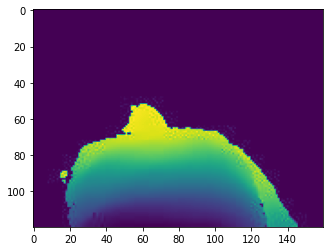

In [69]:
# xtmp = xtrainnew[300,:]
# plt.imshow(np.reshape(xtmp, (x_train.shape[1],x_train.shape[2])))

In [30]:
nsamps = TheData.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#
Trainset = TheData.iloc[rannums,:]
Testset = TheData.iloc[test_set,:]

In [ ]:
sc_X = StandardScaler()
sc_y = StandardScaler()

In [31]:
Xtrainz = Trainset.iloc[:,:-1].values
ytrainz = Trainset.iloc[:,-1:].values
X = sc_X.fit_transform(Xtrainz)
y = sc_y.fit_transform(ytrainz)

In [ ]:
# Fit SVR to the dataset


regressor = SVR(kernel = 'rbf',C = 100)
regressor.fit(X, ravel(y))

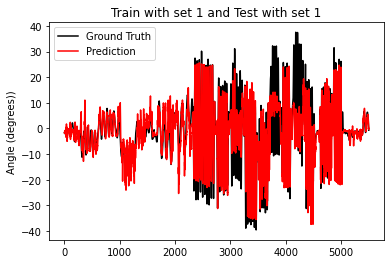

In [33]:
y_pred = regressor.predict(X)
y_new = Y
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r-')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 1')
plt.ylabel('Angle (degrees))')
plt.show()

# Regress using Neural Network

In [37]:
X.shape #7min*30fps*60s/min*0.8 ~ 10800

(10200, 19206)

In [40]:
# Create Neural Netowrk
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(X.shape[1],)))
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(200, activation='relu')) #added extra layer. probably overkill but want good results
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])
    
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn(y_train[:1], predictions).numpy()

epochs = int(30000)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100,restore_best_weights=True) #Moving to 1000 patience. 
history = model.fit(X, y, epochs = epochs,callbacks = [callback],verbose=1)

model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Epoch 1/30000
319/319 [==============================] - 3s 10ms/step - loss: 1.0479 - mse: 3.6683 - mae: 1.0479
Epoch 2/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.6553 - mse: 1.1463 - mae: 0.6553
Epoch 3/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.5993 - mse: 1.0995 - mae: 0.5993
Epoch 4/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.5646 - mse: 0.9916 - mae: 0.5646
Epoch 5/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.5377 - mse: 0.7923 - mae: 0.5377
Epoch 6/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.5218 - mse: 0.8438 - mae: 0.5218
Epoch 7/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.5048 - mse: 0.7198 - mae: 0.5048
Epoch 8/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.4977 - mse: 0.7523 - mae: 0.4977
Epoch 9/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.4745 - mse: 0.61

319/319 [==============================] - 3s 10ms/step - loss: 0.1704 - mse: 0.1054 - mae: 0.1704
Epoch 73/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1750 - mse: 0.1085 - mae: 0.1750
Epoch 74/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1772 - mse: 0.1122 - mae: 0.1772
Epoch 75/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1745 - mse: 0.1078 - mae: 0.1745
Epoch 76/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1685 - mse: 0.1032 - mae: 0.1685
Epoch 77/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1694 - mse: 0.1032 - mae: 0.1694
Epoch 78/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1662 - mse: 0.1033 - mae: 0.1662
Epoch 79/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1698 - mse: 0.1072 - mae: 0.1698
Epoch 80/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1630 - mse: 0.1008 - m

319/319 [==============================] - 3s 10ms/step - loss: 0.1194 - mse: 0.0491 - mae: 0.1194
Epoch 144/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1201 - mse: 0.0588 - mae: 0.1201
Epoch 145/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1195 - mse: 0.0508 - mae: 0.1195
Epoch 146/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1160 - mse: 0.0475 - mae: 0.1160
Epoch 147/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1241 - mse: 0.0591 - mae: 0.1241
Epoch 148/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1201 - mse: 0.0528 - mae: 0.1201
Epoch 149/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1098 - mse: 0.0457 - mae: 0.1098
Epoch 150/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1139 - mse: 0.0443 - mae: 0.1139
Epoch 151/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1174 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0885 - mse: 0.0304 - mae: 0.0885
Epoch 215/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1007 - mse: 0.0491 - mae: 0.1007
Epoch 216/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0904 - mse: 0.0328 - mae: 0.0904
Epoch 217/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0849 - mse: 0.0277 - mae: 0.0849
Epoch 218/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.1027 - mse: 0.0433 - mae: 0.1027
Epoch 219/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0893 - mse: 0.0302 - mae: 0.0893
Epoch 220/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0987 - mse: 0.0376 - mae: 0.0987
Epoch 221/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0925 - mse: 0.0323 - mae: 0.0925
Epoch 222/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0874 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0769 - mse: 0.0228 - mae: 0.0769
Epoch 286/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0799 - mse: 0.0251 - mae: 0.0799
Epoch 287/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0808 - mse: 0.0251 - mae: 0.0808
Epoch 288/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0730 - mse: 0.0212 - mae: 0.0730
Epoch 289/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0755 - mse: 0.0223 - mae: 0.0755
Epoch 290/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0744 - mse: 0.0227 - mae: 0.0744
Epoch 291/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0757 - mse: 0.0237 - mae: 0.0757
Epoch 292/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0701 - mse: 0.0205 - mae: 0.0701
Epoch 293/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0739 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0724 - mse: 0.0220 - mae: 0.0724
Epoch 357/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0754 - mse: 0.0259 - mae: 0.0754
Epoch 358/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0793 - mse: 0.0273 - mae: 0.0793
Epoch 359/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0733 - mse: 0.0209 - mae: 0.0733
Epoch 360/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0723 - mse: 0.0209 - mae: 0.0723
Epoch 361/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0716 - mse: 0.0214 - mae: 0.0716
Epoch 362/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0680 - mse: 0.0183 - mae: 0.0680
Epoch 363/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0759 - mse: 0.0261 - mae: 0.0759
Epoch 364/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0783 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0587 - mse: 0.0120 - mae: 0.0587
Epoch 428/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0646 - mse: 0.0133 - mae: 0.0646
Epoch 429/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0648 - mse: 0.0147 - mae: 0.0648
Epoch 430/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0653 - mse: 0.0140 - mae: 0.0653
Epoch 431/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0540 - mse: 0.0103 - mae: 0.0540
Epoch 432/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0631 - mse: 0.0131 - mae: 0.0631
Epoch 433/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0661 - mse: 0.0130 - mae: 0.0661
Epoch 434/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0608 - mse: 0.0125 - mae: 0.0608
Epoch 435/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0607 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0526 - mse: 0.0095 - mae: 0.0526
Epoch 499/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0634 - mse: 0.0154 - mae: 0.0634
Epoch 500/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0613 - mse: 0.0129 - mae: 0.0613
Epoch 501/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0539 - mse: 0.0104 - mae: 0.0539
Epoch 502/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0553 - mse: 0.0114 - mae: 0.0553
Epoch 503/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0585 - mse: 0.0133 - mae: 0.0585
Epoch 504/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0611 - mse: 0.0136 - mae: 0.0611
Epoch 505/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0589 - mse: 0.0128 - mae: 0.0589
Epoch 506/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0640 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0531 - mse: 0.0108 - mae: 0.0531
Epoch 570/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0555 - mse: 0.0114 - mae: 0.0555
Epoch 571/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0495 - mse: 0.0088 - mae: 0.0495
Epoch 572/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0506 - mse: 0.0094 - mae: 0.0506
Epoch 573/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0542 - mse: 0.0118 - mae: 0.0542
Epoch 574/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0550 - mse: 0.0103 - mae: 0.0550
Epoch 575/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0542 - mse: 0.0099 - mae: 0.0542
Epoch 576/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0579 - mse: 0.0112 - mae: 0.0579
Epoch 577/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0515 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0500 - mse: 0.0098 - mae: 0.0500
Epoch 641/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0535 - mse: 0.0101 - mae: 0.0535
Epoch 642/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0576 - mse: 0.0120 - mae: 0.0576
Epoch 643/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0548 - mse: 0.0119 - mae: 0.0548
Epoch 644/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0508 - mse: 0.0104 - mae: 0.0508
Epoch 645/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0498 - mse: 0.0085 - mae: 0.0498
Epoch 646/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0590 - mse: 0.0130 - mae: 0.0590
Epoch 647/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0596 - mse: 0.0189 - mae: 0.0596
Epoch 648/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0470 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0553 - mse: 0.0110 - mae: 0.0553
Epoch 712/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0466 - mse: 0.0081 - mae: 0.0466
Epoch 713/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0455 - mse: 0.0081 - mae: 0.0455
Epoch 714/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0578 - mse: 0.0132 - mae: 0.0578
Epoch 715/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0546 - mse: 0.0115 - mae: 0.0546
Epoch 716/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0536 - mse: 0.0099 - mae: 0.0536
Epoch 717/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0546 - mse: 0.0106 - mae: 0.0546
Epoch 718/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0517 - mse: 0.0102 - mae: 0.0517
Epoch 719/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0515 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0436 - mse: 0.0073 - mae: 0.0436
Epoch 783/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0477 - mse: 0.0082 - mae: 0.0477
Epoch 784/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0513 - mse: 0.0110 - mae: 0.0513
Epoch 785/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0465 - mse: 0.0081 - mae: 0.0465
Epoch 786/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0500 - mse: 0.0096 - mae: 0.0500
Epoch 787/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0498 - mse: 0.0089 - mae: 0.0498
Epoch 788/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0508 - mse: 0.0104 - mae: 0.0508
Epoch 789/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0462 - mse: 0.0088 - mae: 0.0462
Epoch 790/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0456 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0462 - mse: 0.0081 - mae: 0.0462
Epoch 854/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0457 - mse: 0.0079 - mae: 0.0457
Epoch 855/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0429 - mse: 0.0069 - mae: 0.0429
Epoch 856/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0469 - mse: 0.0086 - mae: 0.0469
Epoch 857/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0445 - mse: 0.0075 - mae: 0.0445
Epoch 858/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0421 - mse: 0.0070 - mae: 0.0421
Epoch 859/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0528 - mse: 0.0113 - mae: 0.0528
Epoch 860/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0446 - mse: 0.0074 - mae: 0.0446
Epoch 861/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0605 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0473 - mse: 0.0084 - mae: 0.0473
Epoch 925/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0414 - mse: 0.0067 - mae: 0.0414
Epoch 926/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0434 - mse: 0.0071 - mae: 0.0434
Epoch 927/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0434 - mse: 0.0075 - mae: 0.0434
Epoch 928/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0409 - mse: 0.0068 - mae: 0.0409
Epoch 929/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0545 - mse: 0.0128 - mae: 0.0545
Epoch 930/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0515 - mse: 0.0098 - mae: 0.0515
Epoch 931/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0552 - mse: 0.0123 - mae: 0.0552
Epoch 932/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0739 - mse: 0.

319/319 [==============================] - 3s 10ms/step - loss: 0.0423 - mse: 0.0069 - mae: 0.0423
Epoch 996/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0648 - mse: 0.0180 - mae: 0.0648
Epoch 997/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0561 - mse: 0.0108 - mae: 0.0561
Epoch 998/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0430 - mse: 0.0070 - mae: 0.0430
Epoch 999/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0410 - mse: 0.0066 - mae: 0.0410
Epoch 1000/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0415 - mse: 0.0067 - mae: 0.0415
Epoch 1001/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0518 - mse: 0.0106 - mae: 0.0518
Epoch 1002/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0406 - mse: 0.0066 - mae: 0.0406
Epoch 1003/30000
319/319 [==============================] - 3s 10ms/step - loss: 0.0526 - mse

AttributeError: 'History' object has no attribute 'save'

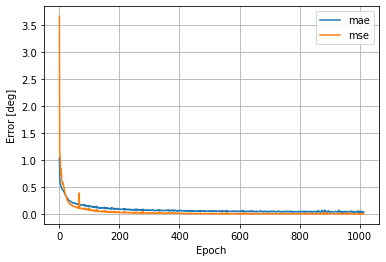

In [42]:
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['mse'], label='mse')
    plt.xlabel('Epoch')
    plt.ylabel('Error [deg]')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

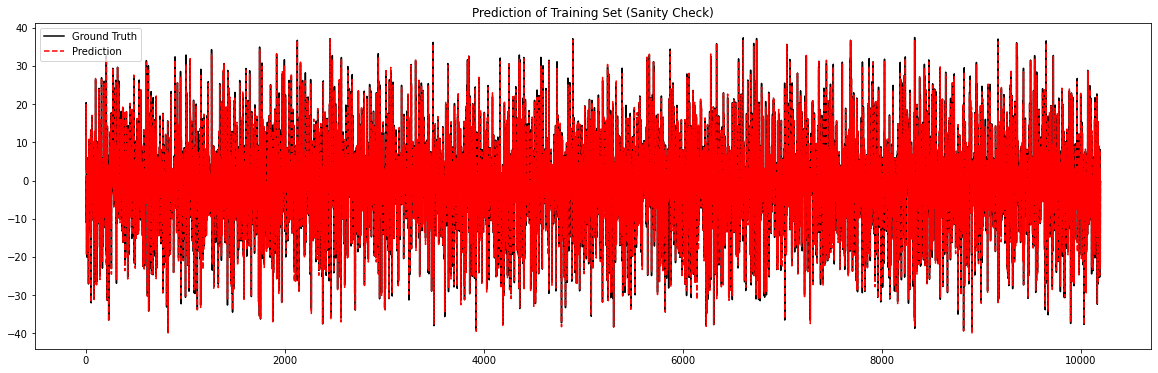

Average error is -0.01 degrees
Root Mean Squared Error is 0.37 degrees


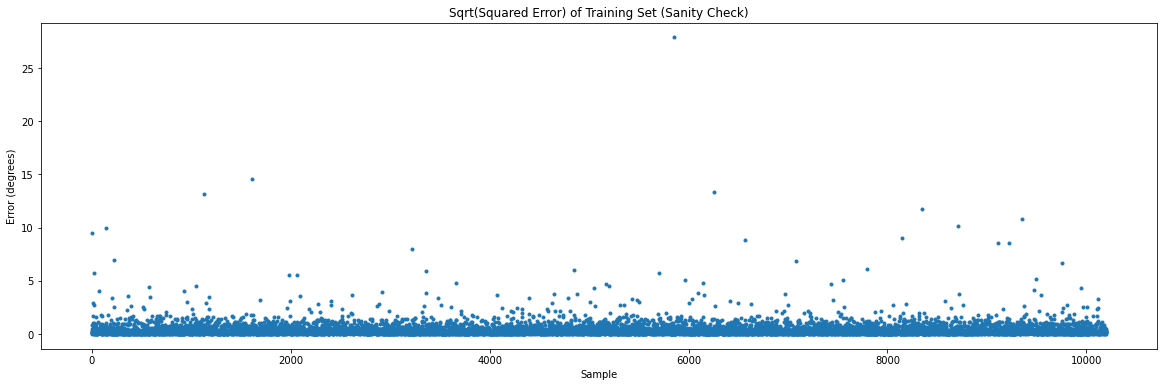

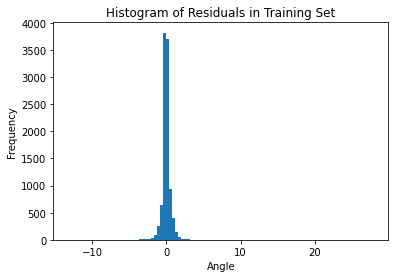

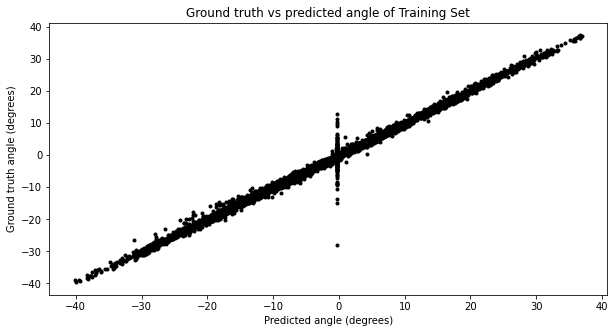

In [54]:

# sanity check with 80% data
Xtrain = Trainset.iloc[:,:-1].values
Xtrain = sc_X.transform(Xtrain)
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainset.iloc[:,-1:].values
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

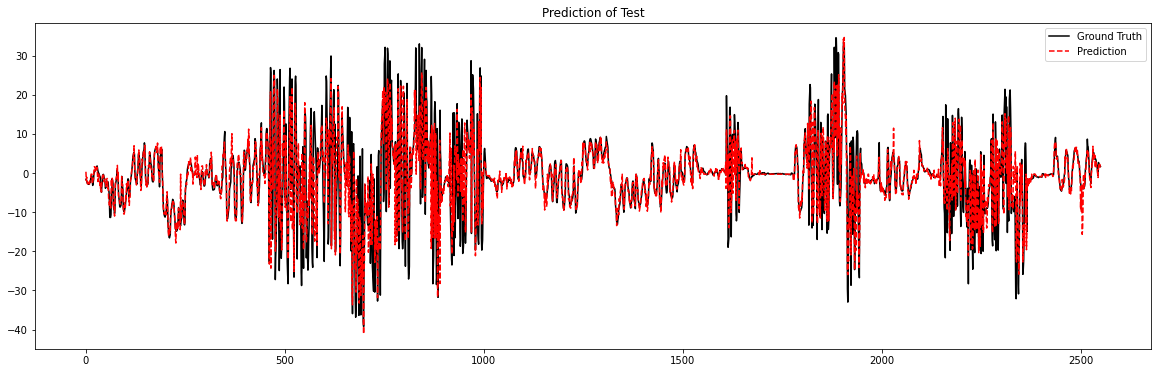

Average error is 0.06 degrees
Root Mean Squared Error is 3.09 degrees


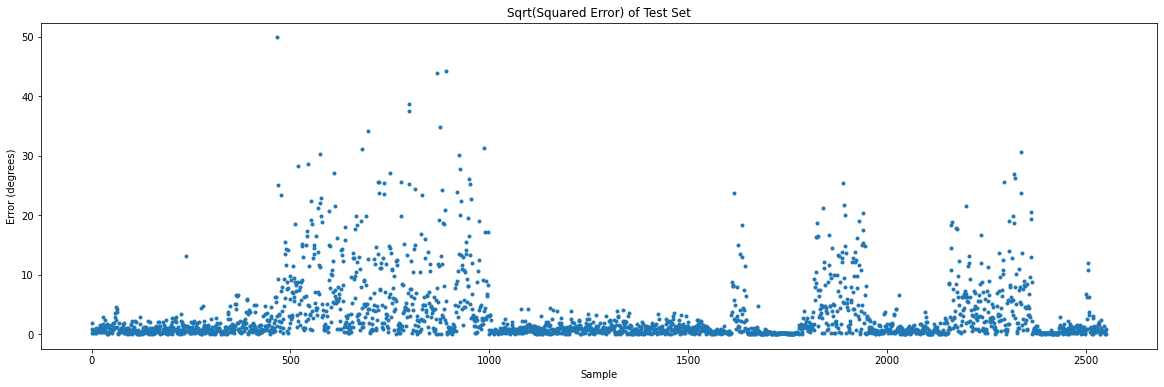

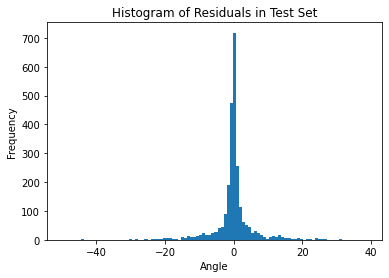

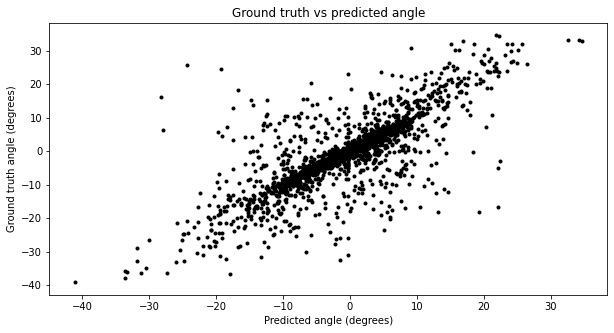

In [52]:
# Redo test set
Xtest = Testset.iloc[:,:-1].values
Xtest = sc_X.transform(Xtest)
y_pred = model.predict(Xtest)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testset.iloc[:,-1:].values

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [51]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodel_nn.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_X,sc_y,modelhistory], file)
        
    model.save('depthforcemodel_nn.h5') 